<a href="https://colab.research.google.com/github/audrb1999/ML-DL-Study/blob/main/Tensorflow/%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/02.%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 이전에 사용했던 기능은 mlp이긴 했지만 cnn이 아니였습니다. 여기서는 cnn을 사용하여 모델을 구축해봅시다.

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D # 완전연결 계층 + 1차원화 + 합성곱
from tensorflow.keras import Model # 층을 설계하기 위한 모델을 불러옴

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 4.3MB 34.2MB/s 
     |████████████████████████████████| 501kB 34.7MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 


In [ ]:
tf.__version__

'2.0.0-rc1'

- Mnist 데이터 셋을 준비합니다.

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 차원을 추가하는 방법 tf.expand_dims(train_x, 1) 1이면 앞에 추가 (1, 60000, 28, 28)
# -1이면 뒤에 추가 (60000, 28, 28, 1)
# 또 다른 차원 추가 방법

print('\n전', x_train.shape)
x_train = x_train[..., tf.newaxis]
print('\n후', x_train.shape)

x_test = x_test[..., tf.newaxis]


전 (60000, 28, 28)

후 (60000, 28, 28, 1)


tf.data를 사용하여 데이터셋을 섞고 배치를 만듭니다.

In [ ]:
# 튜플 형태로 데이터 셋을 만들고 셔플을 해줌

print(x_train.shape)

y_train = y_train.reshape(60000, 1)
y_test = y_test.reshape(10000, 1)

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)



(60000, 28, 28, 1)


In [ ]:
# 이전에 keras로 층을 이어준거와 달리 함수로 만들어서 작성함

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()

필요한 최적화 함수와 손실 함수를 선택합니다.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

모델의 손실과 성능을 측정할 지표를 선택합니다. 에포크가 진행되는 동안 수집된 측정 지표를 바탕으로 최종 결과를 출력합니다.


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss') # 주어진 가중 평균을 계산합니다. [1, 2, 3] = 2 이렇게

# 예측값과 타겟값이 얼마나 자주 매칭되는지 계산해줍니다.
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy') 

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

tf.GradientTape을 사용하여 모델을 훈련합니다.

- 자동 미분을 위한  API로 tf.GradientTape안에 실행되는 모든 연산을 테이프(tape)에 기록을 합니다.


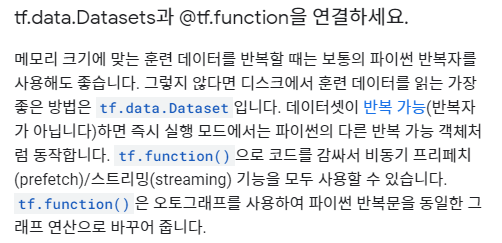


In [ ]:
@tf.function

def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images) # 예측을 진행
        loss = loss_object(labels, predictions)# 크로스 엔트로피로 손실을 구함
    
    gradients = tape.gradient(loss, model.trainable_variables)# 미분 진행
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # 가중치 갱신
    train_loss(loss) # 가중 평균 계산(전체 loss값)
    train_accuracy(labels, predictions)# 몇 개가 맞았는지 계산


모델 테스트

In [ ]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

에포크: 1, 손실: 0.13789483904838562, 정확도: 95.76000213623047, 테스트 손실: 0.06604301184415817, 테스트 정확도: 97.70999908447266
에포크: 2, 손실: 0.09023158997297287, 정확도: 97.22083282470703, 테스트 손실: 0.05987118184566498, 테스트 정확도: 97.90999603271484
에포크: 3, 손실: 0.06771866977214813, 정확도: 97.90833282470703, 테스트 손실: 0.05801469460129738, 테스트 정확도: 98.07333374023438
에포크: 4, 손실: 0.05430703982710838, 정확도: 98.31541442871094, 테스트 손실: 0.05819959193468094, 테스트 정확도: 98.13249969482422
에포크: 5, 손실: 0.045459721237421036, 정확도: 98.58599853515625

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

     |████████████████████████████████| 380.5MB 44kB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 4.3MB 43.4MB/s 
     |████████████████████████████████| 501kB 38.7MB/s 


In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 채널 차원을 추가합니다.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

에포크: 1, 손실: 0.13904203474521637, 정확도: 95.79833221435547, 테스트 손실: 0.059112098067998886, 테스트 정확도: 98.12999725341797
에포크: 2, 손실: 0.09107758849859238, 정확도: 97.22416687011719, 테스트 손실: 0.059575218707323074, 테스트 정확도: 98.0999984741211
에포크: 3, 손실: 0.06805794686079025, 정확도: 97.91610717773438, 테스트 손실: 0.05991003289818764, 테스트 정확도: 98.1199951171875
에포크: 4, 손실: 0.0544438436627388, 정확도: 98.32333374023438, 테스트 손실: 0.06197056174278259, 테스트 정확도: 98.14749908447266
에포크: 5, 손실: 0.04548699036240578, 정확도: 98.59033203125, 테스트 손실: 0.06500194221735, 테스트 정확도: 98.13600158691406
